<a href="https://colab.research.google.com/github/Nathan2605/Ant-Colony-Optimization-ACO-/blob/main/aco7asNH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# ----------------------------------------
# FUNCIONES DE INICIALIZACIÓN Y PREPARACIÓN
# ----------------------------------------

# Lee la instancia de ciudades en formato diccionario y devuelve un array NumPy
def read_instance(data):
    return np.array(list(data.values()))


# Calcula las distancias entre todas las ciudades utilizando la distancia euclidiana
def compute_distances(cities):
    n = len(cities)
    distance = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            x1, y1 = cities[i]
            x2, y2 = cities[j]
            distance[i][j] = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance


# Inicializa la matriz de feromonas con un valor inicial
def initialize_pheromone(cities, initial_value):
    n = len(cities)
    return np.full((n, n), initial_value)


# Inicializa un conjunto de hormigas, cada una con un Tour, Ciudades visitadas, y Longitud del tour (nuestro fitness)
def initialize_ants(num_ants, cities):
    n = len(cities)
    ants = []

    for _ in range(num_ants):
        ant = {
            'tour': np.full(n + 1, -1),  # Tamano del tour +1 considerando regresando a origen, -1: paso no realizado
            'visited': np.zeros(n),      # Ciudades visitadas
            'tour_length': 0             # Longitud del tour
        }
        ants.append(ant)

    return ants

In [ ]:
# ----------------------------------------
# FUNCIONES PRINCIPALES DEL ALGORITMO ACO
# ----------------------------------------


# Calcula las probabilidades de transición entre ciudades basadas en las distancias y feromonas
def compute_proba(distance, pheromone, alpha, beta):
    n = len(distance)
    choice = np.zeros((n, n))

    # Calcular el choice: numerador del cálculo de probabilidades (pheromone^alpha * heuristic^beta)
    for i in range(n):
        for j in range(n):
            if distance[i][j] != 0:  # Evitar divisiones por cero
                heuristic = 1 / distance[i][j]
                choice[i][j] = (pheromone[i][j]**alpha) * (heuristic**beta)

    # Calcular las probabilidades de transición para cada ciudad
    proba = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            proba[j][i] = choice[i][j] / sum(choice[:,i]) #invertir j con i para ir por columnas

    return proba


# Encuentra la ciudad actual de una hormiga basada en su recorrido
def compute_current_city(ant):
    i = 0
    while ant['tour'][i] != -1 and i < len(ant['tour']) - 1:
        i += 1
        current_city = ant['tour'][i-1]
    return int(current_city)


# Regla de decisión para seleccionar la siguiente ciudad utilizando la ruleta
def as_decision_rule(ant, proba):
    current_city = compute_current_city(ant)

    # Probabilidades de ciudades no visitadas
    proba_current_city = proba[:, current_city] * (1 - ant['visited']) #Eliminar prob. de ciudades visitadas
    proba_current_city_acum = np.cumsum(proba_current_city)  # Probabilidades acumulativas

    # Selección usando ruleta
    r = np.random.uniform(0, max(proba_current_city_acum)) #estandiracion de p en base a max, usamos el max porque el acumulado ya no da 1, y uniforme para poner max un float
    i = 0
    while r > proba_current_city_acum[i]:
        i = i+1
    next_city = i
    return next_city


# Actualiza la ciudad visitada por la hormiga
def visit_city(ant, city):
    #marcar ciudad como visitada en 'visited'
    ant['visited'][city] = 1

    #agreagar visita de la ciudad en 'tour'
    i = 0
    while ant['tour'][i] != -1 and i < len(ant['tour']) - 1:
        i += 1
    ant['tour'][i] = city
    return ant


# Completa el recorrido de una hormiga y calcula la longitud total del tour
def complete_tour(ant):
    if all(ant['visited'] == 1):
        ant['tour'][-1] = ant['tour'][0]  # Volver a la ciudad inicial

    #calcular fitness (tour_lenght)
        acum = 0
        for i in range(1, len(ant['tour'])):
            acum = acum + distance[ant['tour'][i]][ant['tour'][i-1]]
        ant['tour_length'] = acum
    return ant


# Construye la solución para un conjunto de hormigas
def construct_solucion(num_ants, cities):

  start_cities = np.random.choice(len(cities), num_ants)  #ciudades iniciales
  ants = []

  for i in range(num_ants):
    ant = initialize_ants(1, cities)[0]  #inicializa una hormiga
    ant = visit_city(ant, start_cities[i])  #asignar ciudad inicial

    for step in range(1, len(cities)):
      next_city = as_decision_rule(ant, proba)
      ant = visit_city(ant, next_city)

    ant = complete_tour(ant)
    ants.append(ant)
  return ants

In [ ]:
# ----------------------------------------
# FUNCIONES PARA ACTUALIZAR FEROMONAS
# ----------------------------------------

# Evapora las feromonas en cada iteración
def evaporate_pheromone(pheromone, evaporation_rate):
    return pheromone * (1 - evaporation_rate)


# Calcula el valor de depósito de feromonas basado en la longitud del tour
def pheromone_deposit_value(ant):
    return 1 / ant['tour_length']


# Actualiza las feromonas depositadas por las hormigas
def deposit_pheromone(pheromone, ants):
    for ant in ants:
        for i in range(len(ant['tour']) - 1):
            city_from = ant['tour'][i]
            city_to = ant['tour'][i + 1]
            pheromone[city_from][city_to] = pheromone[city_from][city_to] + pheromone_deposit_value(ant)
            pheromone[city_to][city_from] = pheromone[city_from][city_to]  #simetría
    return pheromone

In [ ]:
# ----------------------------------------
# FUNCIONES PARA EVALUAR LAS SOLUCIONES
# ----------------------------------------

# Encuentra la mejor hormiga en función de la longitud del tour
def find_best_ant(ants_total):
    best_ant = None
    best_tour_length = 10**(20)

    for ants in ants_total:
        for ant in ants:
            if ant['tour_length'] < best_tour_length:
                best_tour_length = ant['tour_length']
                best_ant = ant

    return best_ant

def find_best_ant_iteration(ants):
    best_ant = None
    best_tour_length = 10**(20)

    for ant in ants:
        if ant['tour_length'] < best_tour_length:
            best_tour_length = ant['tour_length']
            best_ant = ant

    return best_ant

# Devuelve grafica del mejor tour
def plot_best_tour(mejor_hormiga, cities, cities_dict):
    tour = mejor_hormiga['tour']
    x_coords = [cities[city][0] for city in tour]
    y_coords = [cities[city][1] for city in tour]
    plt.plot(x_coords, y_coords, '-')

    # Agregar nombres de ciudades
    for city in tour:
        city_name = list(cities_dict.keys())[city]
        plt.text(cities[city][0], cities[city][1], city_name, ha='center', va='center', fontsize=8)

    plt.title(f'Mejor hormiga: {mejor_hormiga["tour_length"]}')
    plt.show()

#### principal


f Mejor hormiga: {'tour': array([ 2, 12, 11,  3, 13, 20,  9, 17, 15, 22, 21,  4,  6, 14,  8, 23,  5,
       24, 19,  0,  1, 16, 10,  7, 18,  2]), 'visited': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.]), 'tour_length': 55.79804462981559}


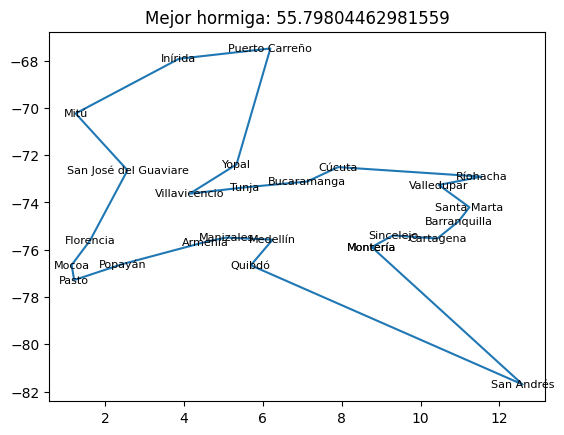

In [ ]:
# ----------------------------------------
# PROGRAMA PRINCIPAL
# ----------------------------------------

# Cargar los datos de las ciudades
URL = "https://raw.githubusercontent.com/it-ces/GA-OPTA-PUJ/main/cities.csv"
data = pd.read_csv(URL)
data = data[data['capital'] == 'admin'].sample(25, random_state=4).reset_index(drop=True)
cities_dict = {data.loc[i, 'city']: [data.loc[i, 'lat'], data.loc[i, 'lng']] for i in data.index}
cities = read_instance(cities_dict)

# Parámetros del algoritmo ACO
alpha = 1
beta = 3
initial_pheromone = 10**(-100)
num_ants = 30
evaporation_rate = 0.5
iterations = 100

# Inicialización
distance = compute_distances(cities)
pheromone = initialize_pheromone(cities, initial_pheromone)
proba = compute_proba(distance, pheromone, alpha, beta)
ants = initialize_ants(num_ants,cities)
ants_total = []

# Iteraciones del ACO
for _ in range(iterations):
    ants = construct_solucion(num_ants, cities)
    pheromone = evaporate_pheromone(pheromone, evaporation_rate)
    pheromone = deposit_pheromone(pheromone, ants)
    proba = compute_proba(distance, pheromone, alpha, beta)
    #print(f'iteracion {_}: {ants}')
    ants_total.append(ants)

    mejor_hormiga_iteration = find_best_ant_iteration(ants)
    #print(f"Mejor hormiga iteracion {_}: {mejor_hormiga_iteration}, Longitud del tour: {mejor_hormiga_iteration['tour_length']}")

# Encontrar la mejor hormiga
mejor_hormiga = find_best_ant(ants_total)
print(f"f Mejor hormiga: {mejor_hormiga}")

#Graficar la ruta de la mejor hormiga
plot_best_tour(mejor_hormiga, cities, cities_dict)

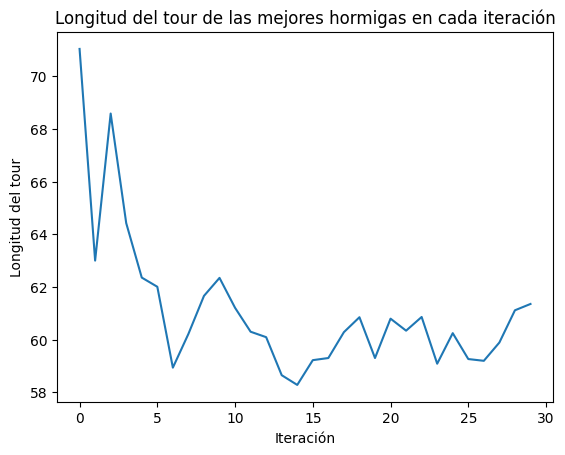

In [ ]:
best_tour_lengths = []
for ants in ants_total:
    best_ant = find_best_ant_iteration(ants)
    best_tour_lengths.append(best_ant['tour_length'])

plt.plot(best_tour_lengths)
plt.xlabel('Iteración')
plt.ylabel('Longitud del tour')
plt.title('Longitud del tour de las mejores hormigas en cada iteración')
plt.show()



---



#### PASEO POR EL ALGORITMO

In [ ]:
data2 = {'cityA':(10,20),
        'cityB':(30,25),
        'cityC':(13,33),
        'cityD':(21,12),
        'cityE':(20,25),}
        #'cityF':(23,32),}

In [ ]:
#leemos nuestras ciudades
cities2 = read_instance(data2)

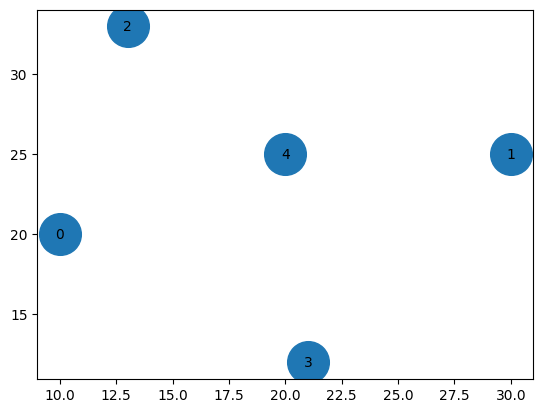

In [ ]:
#graficar
x = cities2[:, 0]
y = cities2[:, 1]
plt.plot(x, y, 'o',markersize=30)
#numerotacion
for i in range(len(x)):
    plt.text(x[i], y[i], str(i), ha='center', va='center')

In [ ]:
#calculamos la matriz de distancias entre las ciudades
distance2 = compute_distances(cities2)
print(distance2)

[[ 0.         20.61552813 13.34166406 13.60147051 11.18033989]
 [20.61552813  0.         18.78829423 15.8113883  10.        ]
 [13.34166406 18.78829423  0.         22.47220505 10.63014581]
 [13.60147051 15.8113883  22.47220505  0.         13.03840481]
 [11.18033989 10.         10.63014581 13.03840481  0.        ]]


In [ ]:
#creamos una matriz, sera nuestra matriz de feromonas, un valor para cada link, inicialiamos un t0
t0 = 0.001
pheromone2 = initialize_pheromone(cities2, t0)
print(pheromone2)

[[0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001]]




---




$$P_{ij}^k(t) = \frac{[\tau_{ij}(t)]^\alpha [\eta_{ij}]^\beta}{\sum_{l \in N_i^k} [\tau_{il}(t)]^\alpha [\eta_{il}]^\beta}$$

Donde:

*   $P_{ij}^k(t)$ es la probabilidad de que la hormiga $k$ se mueva de la ciudad $i$ a la ciudad $j$ en el tiempo $t$.
*   $\tau_{ij}(t)$ es la cantidad de feromona en el camino entre las ciudades $i$ y $j$ en el tiempo $t$.
*   $\eta_{ij}$ es la visibilidad del camino entre las ciudades $i$ y $j$, que suele ser la inversa de la distancia entre las ciudades.
*   $\alpha$ y $\beta$ son parámetros que controlan la influencia relativa de la feromona y la visibilidad.
*   $N_i^k$ es el conjunto de ciudades vecinas a la ciudad $i$ que la hormiga $k$ aún no ha visitado.

In [ ]:
#calculamos nuestras probabilidades inciales
alpha = 1
beta = 3
proba = compute_proba(distance2, pheromone2, alpha, beta)
print(proba)

[[0.         0.07519258 0.28213846 0.33405367 0.23857802]
 [0.06924898 0.         0.10102532 0.21264923 0.33342292]
 [0.25548579 0.09933363 0.         0.07406905 0.27757336]
 [0.24112329 0.16666652 0.05904121 0.         0.15042571]
 [0.43414194 0.65880727 0.55779501 0.37922805 0.        ]]




---

ITERACION 0:

In [ ]:
#creamos 3 hormigas para hacer un test
num_ants_test = 3
ants_test = initialize_ants(num_ants_test,cities2)
ants_test

[{'tour': array([-1, -1, -1, -1, -1, -1]),
  'visited': array([0., 0., 0., 0., 0.]),
  'tour_length': 0},
 {'tour': array([-1, -1, -1, -1, -1, -1]),
  'visited': array([0., 0., 0., 0., 0.]),
  'tour_length': 0},
 {'tour': array([-1, -1, -1, -1, -1, -1]),
  'visited': array([0., 0., 0., 0., 0.]),
  'tour_length': 0}]

In [ ]:
#generamos unas ciudades de inicio aleatorias
start_cities2 = np.random.choice(len(cities2), num_ants_test)
start_cities2

array([4, 2, 1])

In [ ]:
#Le asignamos a cada hormiga su ciudad de incio aleatoriamente y las mandamos alla
for i in range(num_ants_test):
    print(start_cities2[i])
    ants_test[i] = visit_city(ants_test[i], start_cities2[i])  #asignar ciudad inicial
    print(ants_test[i])

4
{'tour': array([ 4, -1, -1, -1, -1, -1]), 'visited': array([0., 0., 0., 0., 1.]), 'tour_length': 0}
2
{'tour': array([ 2, -1, -1, -1, -1, -1]), 'visited': array([0., 0., 1., 0., 0.]), 'tour_length': 0}
1
{'tour': array([ 1, -1, -1, -1, -1, -1]), 'visited': array([0., 1., 0., 0., 0.]), 'tour_length': 0}


In [ ]:
#las hormigas hacen su recorrido
for step in range(1, len(cities2)):
  for i in range(num_ants_test):

      print(f'\nSTEP {step}')
      print(f'HORMIGA {i}')
      next_city = as_decision_rule(ants_test[i], proba) #se determina con una roulette la siguiente ciudad a visitar

      print(next_city)
      ant = visit_city(ants_test[i], next_city) #las movemos a esta ciudad
      print(ants_test[i])


STEP 1
HORMIGA 0
1
{'tour': array([ 4,  1, -1, -1, -1, -1]), 'visited': array([0., 1., 0., 0., 1.]), 'tour_length': 0}

STEP 1
HORMIGA 1
4
{'tour': array([ 2,  4, -1, -1, -1, -1]), 'visited': array([0., 0., 1., 0., 1.]), 'tour_length': 0}

STEP 1
HORMIGA 2
3
{'tour': array([ 1,  3, -1, -1, -1, -1]), 'visited': array([0., 1., 0., 1., 0.]), 'tour_length': 0}

STEP 2
HORMIGA 0
3
{'tour': array([ 4,  1,  3, -1, -1, -1]), 'visited': array([0., 1., 0., 1., 1.]), 'tour_length': 0}

STEP 2
HORMIGA 1
3
{'tour': array([ 2,  4,  3, -1, -1, -1]), 'visited': array([0., 0., 1., 1., 1.]), 'tour_length': 0}

STEP 2
HORMIGA 2
4
{'tour': array([ 1,  3,  4, -1, -1, -1]), 'visited': array([0., 1., 0., 1., 1.]), 'tour_length': 0}

STEP 3
HORMIGA 0
2
{'tour': array([ 4,  1,  3,  2, -1, -1]), 'visited': array([0., 1., 1., 1., 1.]), 'tour_length': 0}

STEP 3
HORMIGA 1
0
{'tour': array([ 2,  4,  3,  0, -1, -1]), 'visited': array([1., 0., 1., 1., 1.]), 'tour_length': 0}

STEP 3
HORMIGA 2
2
{'tour': array([ 1, 

In [ ]:
#acompletamos el recorrido regresando a ciudad origen y calculamos nuestro fitness
for i in range(num_ants_test):
  ants_test[i] = complete_tour(ants_test[i])
ants_test

[{'tour': array([4, 1, 3, 2, 0, 4]),
  'visited': array([1., 1., 1., 1., 1.]),
  'tour_length': 23.7894405177184},
 {'tour': array([2, 4, 3, 0, 1, 2]),
  'visited': array([1., 1., 1., 1., 1.]),
  'tour_length': 26.25748068066099},
 {'tour': array([1, 3, 4, 2, 0, 1]),
  'visited': array([1., 1., 1., 1., 1.]),
  'tour_length': 26.16249127796289}]

In [ ]:
#guardamos nuestros recorridos
ants_total_test = []
ants_total_test.append(ants_test)
ants_total_test

[[{'tour': array([4, 1, 3, 2, 0, 4]),
   'visited': array([1., 1., 1., 1., 1.]),
   'tour_length': 23.7894405177184},
  {'tour': array([2, 4, 3, 0, 1, 2]),
   'visited': array([1., 1., 1., 1., 1.]),
   'tour_length': 26.25748068066099},
  {'tour': array([1, 3, 4, 2, 0, 1]),
   'visited': array([1., 1., 1., 1., 1.]),
   'tour_length': 26.16249127796289}]]



---



Feromonas: $$
\tau_{ij}(t+1) = (1 - \rho) \cdot \tau_{ij}(t) + \sum_{k=1}^{m} \Delta \tau_{ij}^k(t)
$$

Donde:

*   $\tau_{ij}(t)$ es la cantidad de feromona en el camino entre las ciudades  $i$  y  $j$  en el tiempo  $t$.
*   $\rho$  es la tasa de evaporación de la feromona.
*   $\Delta \tau_{ij}^k(t) = 1 / C_{k}$ la cantidad de feromona depositada por la hormiga $k$  en el camino entre las ciudades  $i$  y  $j$  en el tiempo  $t$.
* $C_{k}$ es la longitud del tour recorrido por hormiga $k$.
*   $m$  es el número de hormigas.

In [ ]:
pheromone2

array([[0.001, 0.001, 0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001, 0.001, 0.001]])

In [ ]:
#evaporar los feromonas, para evitar estancamiento y quedar un no optimo rapido
evaporation_rate = 0.5
pheromone2 = evaporate_pheromone(pheromone2, evaporation_rate)

In [ ]:
#reforzamos las rutas visitadas segun su fitness
pheromone2 = deposit_pheromone(pheromone2, ants_test)

In [ ]:
pheromone2

array([[0.0005    , 0.07680704, 0.08075812, 0.03858438, 0.04253546],
       [0.07680704, 0.0005    , 0.03858438, 0.08075812, 0.04253546],
       [0.08075812, 0.03858438, 0.0005    , 0.04253546, 0.07680704],
       [0.03858438, 0.08075812, 0.04253546, 0.0005    , 0.07680704],
       [0.04253546, 0.04253546, 0.07680704, 0.07680704, 0.0005    ]])

In [ ]:
#con las nuevas feromonas actualizamos las probabilidades
print('PROBABILIDADES ITERACION 0')
print(proba)
proba = compute_proba(distance2, pheromone2, alpha, beta)
print('\nPROBABILIDADES ITERACION 1')
print(proba)

PROBABILIDADES ITERACION 0
[[0.         0.07519258 0.28213846 0.33405367 0.23857802]
 [0.06924898 0.         0.10102532 0.21264923 0.33342292]
 [0.25548579 0.09933363 0.         0.07406905 0.27757336]
 [0.24112329 0.16666652 0.05904121 0.         0.15042571]
 [0.43414194 0.65880727 0.55779501 0.37922805 0.        ]]

PROBABILIDADES ITERACION 1
[[0.         0.11304122 0.31629582 0.20675621 0.17740166]
 [0.09900731 0.         0.05411115 0.27547408 0.24792636]
 [0.38406592 0.07501855 0.         0.05053807 0.37269622]
 [0.17318233 0.26344826 0.03486192 0.         0.20197577]
 [0.34374444 0.54849197 0.59473111 0.46723164 0.        ]]




---

ITERACION 1:

In [ ]:
#reinicializamos las 3 hormigas para hacer un test
num_ants_test = 3
ants_test = initialize_ants(num_ants_test,cities2)
ants_test

[{'tour': array([-1, -1, -1, -1, -1, -1]),
  'visited': array([0., 0., 0., 0., 0.]),
  'tour_length': 0},
 {'tour': array([-1, -1, -1, -1, -1, -1]),
  'visited': array([0., 0., 0., 0., 0.]),
  'tour_length': 0},
 {'tour': array([-1, -1, -1, -1, -1, -1]),
  'visited': array([0., 0., 0., 0., 0.]),
  'tour_length': 0}]

In [ ]:
#generamos de nuevo unas ciudades de inicio aleatorias
start_cities2 = np.random.choice(len(cities2), num_ants_test)
start_cities2

array([2, 4, 1])

In [ ]:
#Le asignamos a cada hormiga su ciudad de incio aleatoriamente y las mandamos alla
for i in range(num_ants_test):
    print(start_cities2[i])
    ants_test[i] = visit_city(ants_test[i], start_cities2[i])  #asignar ciudad inicial
    print(ants_test[i])

2
{'tour': array([ 2, -1, -1, -1, -1, -1]), 'visited': array([0., 0., 1., 0., 0.]), 'tour_length': 0}
4
{'tour': array([ 4, -1, -1, -1, -1, -1]), 'visited': array([0., 0., 0., 0., 1.]), 'tour_length': 0}
1
{'tour': array([ 1, -1, -1, -1, -1, -1]), 'visited': array([0., 1., 0., 0., 0.]), 'tour_length': 0}


In [ ]:
#las hormigas hacen su recorrido
for step in range(1, len(cities2)):
  for i in range(num_ants_test):

      print(f'\nSTEP {step}')
      print(f'HORMIGA {i}')
      next_city = as_decision_rule(ants_test[i], proba) #se determina con una roulette la siguiente ciudad a visitar

      print(next_city)
      ant = visit_city(ants_test[i], next_city) #las movemos a esta ciudad
      print(ants_test[i])


STEP 1
HORMIGA 0
4
{'tour': array([ 2,  4, -1, -1, -1, -1]), 'visited': array([0., 0., 1., 0., 1.]), 'tour_length': 0}

STEP 1
HORMIGA 1
2
{'tour': array([ 4,  2, -1, -1, -1, -1]), 'visited': array([0., 0., 1., 0., 1.]), 'tour_length': 0}

STEP 1
HORMIGA 2
4
{'tour': array([ 1,  4, -1, -1, -1, -1]), 'visited': array([0., 1., 0., 0., 1.]), 'tour_length': 0}

STEP 2
HORMIGA 0
3
{'tour': array([ 2,  4,  3, -1, -1, -1]), 'visited': array([0., 0., 1., 1., 1.]), 'tour_length': 0}

STEP 2
HORMIGA 1
0
{'tour': array([ 4,  2,  0, -1, -1, -1]), 'visited': array([1., 0., 1., 0., 1.]), 'tour_length': 0}

STEP 2
HORMIGA 2
2
{'tour': array([ 1,  4,  2, -1, -1, -1]), 'visited': array([0., 1., 1., 0., 1.]), 'tour_length': 0}

STEP 3
HORMIGA 0
0
{'tour': array([ 2,  4,  3,  0, -1, -1]), 'visited': array([1., 0., 1., 1., 1.]), 'tour_length': 0}

STEP 3
HORMIGA 1
3
{'tour': array([ 4,  2,  0,  3, -1, -1]), 'visited': array([1., 0., 1., 1., 1.]), 'tour_length': 0}

STEP 3
HORMIGA 2
0
{'tour': array([ 1, 

In [ ]:
#acompletamos el recorrido regresando a ciudad origen y calculamos nuestro fitness
for i in range(num_ants_test):
  ants_test[i] = complete_tour(ants_test[i])
ants_test

[{'tour': array([2, 4, 3, 0, 1, 2]),
  'visited': array([1., 1., 1., 1., 1.]),
  'tour_length': 26.25748068066099},
 {'tour': array([4, 2, 0, 3, 1, 4]),
  'visited': array([1., 1., 1., 1., 1.]),
  'tour_length': 29.829666457587656},
 {'tour': array([1, 4, 2, 0, 3, 1]),
  'visited': array([1., 1., 1., 1., 1.]),
  'tour_length': 29.829666457587653}]

In [ ]:
#guardamos nuestros recorridos
ants_total_test.append(ants_test)
ants_total_test

[[{'tour': array([4, 1, 3, 2, 0, 4]),
   'visited': array([1., 1., 1., 1., 1.]),
   'tour_length': 23.7894405177184},
  {'tour': array([2, 4, 3, 0, 1, 2]),
   'visited': array([1., 1., 1., 1., 1.]),
   'tour_length': 26.25748068066099},
  {'tour': array([1, 3, 4, 2, 0, 1]),
   'visited': array([1., 1., 1., 1., 1.]),
   'tour_length': 26.16249127796289}],
 [{'tour': array([2, 4, 3, 0, 1, 2]),
   'visited': array([1., 1., 1., 1., 1.]),
   'tour_length': 26.25748068066099},
  {'tour': array([4, 2, 0, 3, 1, 4]),
   'visited': array([1., 1., 1., 1., 1.]),
   'tour_length': 29.829666457587656},
  {'tour': array([1, 4, 2, 0, 3, 1]),
   'visited': array([1., 1., 1., 1., 1.]),
   'tour_length': 29.829666457587653}]]

In [ ]:
# Encontrar la mejor hormiga
mejor_hormiga_test = find_best_ant(ants_total_test)
print(f"f Mejor hormiga: {mejor_hormiga_test}")

f Mejor hormiga: {'tour': array([4, 1, 3, 2, 0, 4]), 'visited': array([1., 1., 1., 1., 1.]), 'tour_length': 23.7894405177184}


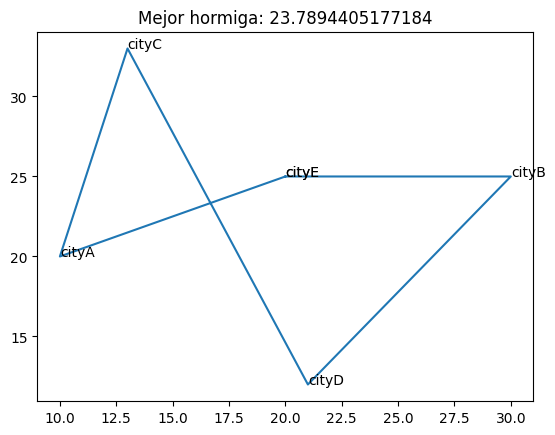

In [ ]:
tour_test = mejor_hormiga_test['tour']
# Get city names corresponding to city indices in tour_test
city_names = [list(data2.keys())[i] for i in tour_test]
x_coords_t = [data2[city][0] for city in city_names]
y_coords_t = [data2[city][1] for city in city_names]

plt.plot(x_coords_t, y_coords_t, '-')
plt.title(f'Mejor hormiga: {mejor_hormiga_test["tour_length"]}')
for i, city in enumerate(city_names):
    plt.annotate(city, (x_coords_t[i], y_coords_t[i]))
plt.show()

In [ ]:
#iterando un poco mas
iterations2 = 100
for _ in range(iterations2):
    ants_test = construct_solucion(num_ants_test, cities2)
    pheromone2 = evaporate_pheromone(pheromone2, evaporation_rate)
    pheromone2 = deposit_pheromone(pheromone2, ants_test)
    proba = compute_proba(distance2, pheromone2, alpha, beta)
    #print(f'iteracion {_}: {ants}')
    ants_total_test.append(ants_test)

# Encontrar la mejor hormiga
mejor_hormiga_test = find_best_ant(ants_total_test)
print(f"f Mejor hormiga: {mejor_hormiga_test}")

f Mejor hormiga: {'tour': array([2, 0, 1, 4, 3, 2]), 'visited': array([1., 1., 1., 1., 1.]), 'tour_length': 20.61592598141604}


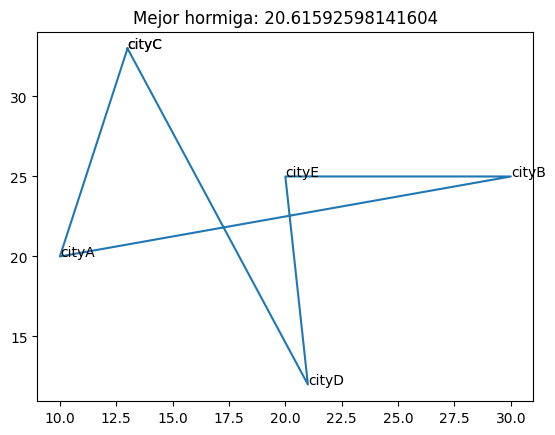

In [ ]:
tour_test = mejor_hormiga_test['tour']
# Get city names corresponding to city indices in tour_test
city_names = [list(data2.keys())[i] for i in tour_test]
x_coords_t = [data2[city][0] for city in city_names]
y_coords_t = [data2[city][1] for city in city_names]

plt.plot(x_coords_t, y_coords_t, '-')
plt.title(f'Mejor hormiga: {mejor_hormiga_test["tour_length"]}')
for i, city in enumerate(city_names):
    plt.annotate(city, (x_coords_t[i], y_coords_t[i]))
plt.show()